# Neural Networks retrieval on the Satellite Observations Dataset

In this final step we develop a model to estimate soil moisture using neural networks

Libraries we need are imported first

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import xarray as xr
from scipy.interpolate import griddata
from scipy import interpolate

import torch
from torch import nn, optim
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader

Data used in this exercise is stored in the DATA folder

In [4]:
thefile = '../../../DATA/TPdata_199301'
orig_data = pd.read_csv(thefile, sep='\t', header=None)
orig_data.columns = ["cellNr", "latitude", "longitude", "backscatter","emissivity_v","emissivity_h","ts_amplitude","ndvi","lmd_soilWetness"]
orig_data = orig_data.replace('   NaN',pd.NA)
data = orig_data
test_data = orig_data
data['backscatter'] = pd.to_numeric(data['backscatter'])
data['emissivity_v'] = pd.to_numeric(data['emissivity_v'])
data['emissivity_h'] = pd.to_numeric(data['emissivity_h'])
data['ts_amplitude'] = pd.to_numeric(data['ts_amplitude'])
data['ndvi'] = pd.to_numeric(data['ndvi'])
data['lmd_soilWetness'] = pd.to_numeric(data['lmd_soilWetness'])
data = data.dropna()
test_data = test_data.dropna()
data = data.iloc[::5,:]
test_data = test_data.iloc[1::5,:]
data = data.iloc[0:len(test_data),:]

In [6]:
thres = len(test_data)

In [8]:
lati = data['latitude']
loni = data['longitude']

In [32]:
normalized_data=(data-data.min())/(data.max()-data.min())
data = normalized_data

In [34]:
back = data['backscatter'].values[0:thres]
lats = data['latitude'].values[0:thres]
lons = data['longitude'].values[0:thres]
emissivity_v = data['emissivity_v'].values[0:thres]
emissivity_h = data['emissivity_h'].values[0:thres]
ts_amplitude = data['ts_amplitude'].values[0:thres]
ndvi = data['ndvi'].values[0:thres]
lmd_soilWetness = data['lmd_soilWetness'].values[0:thres]

## Neural Network

In [37]:
hidden=thres

In [39]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5,hidden)  
        self.fc2 = nn.Linear(hidden,1)  

    def forward(self, x):
        x = torch.relu(self.fc1(x)) 
        x = self.fc2(x)               
        return x

In [41]:
alles = np.stack((back,emissivity_v,emissivity_h,ts_amplitude,ndvi),axis=1)

In [43]:
X_train = torch.tensor(alles).to(torch.float32)
y_train = torch.tensor(lmd_soilWetness).to(torch.float32)
y_train = y_train[...,None]

DataLoader

In [46]:
class MyDataset(Dataset):
    def __init__(self):
        self.data = X_train
        self.labels = y_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = MyDataset()
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# for batch in dataloader:
#     print("Batch Data:", batch[0])  
#     print("Batch Labels:", batch[1])

In [48]:
model = SimpleNN()  
criterion = nn.MSELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.1)
iter=0

In [52]:
for epoch in range(100):  
  for inputs, labels in dataloader:
    model.train() 

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)  
    
    # Backward pass and optimize
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()  

  if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/100], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0125
Epoch [20/100], Loss: 0.0210
Epoch [30/100], Loss: 0.0429
Epoch [40/100], Loss: 0.0213
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0268
Epoch [70/100], Loss: 0.0177
Epoch [80/100], Loss: 0.0487
Epoch [90/100], Loss: 0.0175
Epoch [100/100], Loss: 0.0330


## Performance of the Neural Network

In [55]:
test_data['backscatter'] = pd.to_numeric(test_data['backscatter'])
test_data['emissivity_v'] = pd.to_numeric(test_data['emissivity_v'])
test_data['emissivity_h'] = pd.to_numeric(test_data['emissivity_h'])
test_data['ts_amplitude'] = pd.to_numeric(test_data['ts_amplitude'])
test_data['ndvi'] = pd.to_numeric(test_data['ndvi'])
test_data['lmd_soilWetness'] = pd.to_numeric(test_data['lmd_soilWetness'])

In [57]:
test_normalized_data=(test_data-test_data.min())/(test_data.max()-test_data.min())
test_data = test_normalized_data
test_data

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness
65425,0.000000,0.000000,0.178626,0.721724,0.376164,0.460693,0.377197,0.214447,0.493189
73373,0.014956,0.020979,0.179990,0.559767,0.946741,0.921386,0.535596,0.289824,0.022622
76107,0.020100,0.027972,0.173885,0.637132,0.653259,0.711056,0.685615,0.332538,0.229385
77958,0.023584,0.032634,0.176766,0.585282,0.791061,0.810620,0.621996,0.337060,0.109827
79828,0.027102,0.037296,0.178175,0.624360,0.794786,0.811242,0.605270,0.176759,0.074921
...,...,...,...,...,...,...,...,...,...
589235,0.985661,0.981352,0.474768,0.829738,0.816387,0.870774,0.118818,0.216960,0.811725
590098,0.987285,0.981352,0.436067,0.858108,0.748603,0.814561,0.063336,0.498869,0.625030
591009,0.988999,0.986014,0.476654,0.855750,0.804469,0.846712,0.047317,0.228643,0.690221
593602,0.993879,0.990676,0.432901,0.855523,0.807076,0.854180,0.057931,0.604774,0.782170


In [59]:
test_back = test_data['backscatter'].values[0:thres]
test_lats = test_data['latitude'].values[0:thres]
test_lons = test_data['longitude'].values[0:thres]
test_emissivity_v = test_data['emissivity_v'].values[0:thres]
test_emissivity_h = test_data['emissivity_h'].values[0:thres]
test_ts_amplitude = test_data['ts_amplitude'].values[0:thres]
test_ndvi = test_data['ndvi'].values[0:thres]
test_lmd_soilWetness = test_data['lmd_soilWetness'].values[0:thres]

In [61]:
test_alles = np.stack((test_back,test_emissivity_v,test_emissivity_h,test_ts_amplitude,test_ndvi),axis=1)

In [63]:
model.eval()  
with torch.no_grad(): 
    testing_data = torch.tensor(test_alles).to(torch.float32)
    predictions = model(testing_data) 
    print(f'Predictions:\n{predictions}')

Predictions:
tensor([[0.2597],
        [0.1984],
        [0.0959],
        ...,
        [0.4991],
        [0.4525],
        [0.3483]])


In [65]:
len(predictions)

8906

In [67]:
output = predictions.detach().cpu().numpy()

In [69]:
output

array([[0.25965276],
       [0.19842112],
       [0.09591842],
       ...,
       [0.49909115],
       [0.45252985],
       [0.34832588]], dtype=float32)

In [71]:
np.mean(output)

0.28667063

In [73]:
test_data['NN']=output

In [75]:
test_data

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness,NN
65425,0.000000,0.000000,0.178626,0.721724,0.376164,0.460693,0.377197,0.214447,0.493189,0.259653
73373,0.014956,0.020979,0.179990,0.559767,0.946741,0.921386,0.535596,0.289824,0.022622,0.198421
76107,0.020100,0.027972,0.173885,0.637132,0.653259,0.711056,0.685615,0.332538,0.229385,0.095918
77958,0.023584,0.032634,0.176766,0.585282,0.791061,0.810620,0.621996,0.337060,0.109827,0.118769
79828,0.027102,0.037296,0.178175,0.624360,0.794786,0.811242,0.605270,0.176759,0.074921,0.147824
...,...,...,...,...,...,...,...,...,...,...
589235,0.985661,0.981352,0.474768,0.829738,0.816387,0.870774,0.118818,0.216960,0.811725,0.301475
590098,0.987285,0.981352,0.436067,0.858108,0.748603,0.814561,0.063336,0.498869,0.625030,0.458941
591009,0.988999,0.986014,0.476654,0.855750,0.804469,0.846712,0.047317,0.228643,0.690221,0.499091
593602,0.993879,0.990676,0.432901,0.855523,0.807076,0.854180,0.057931,0.604774,0.782170,0.452530


(-180.0, 180.0)

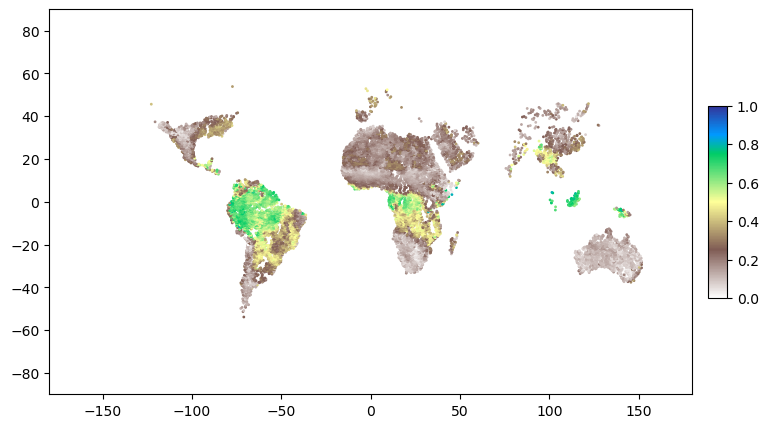

In [77]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.scatter(loni,lati,c=test_data['NN'],s=1, cmap='terrain_r', vmin=0, vmax=1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
ax.set_ylim(-90,90)
ax.set_xlim(-180,180)